# Alarm

In [1]:
from IPython.display import Audio

# progressbar

In [2]:
import IPython
def progress(value, max=100):
    return IPython.display.HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Import modules

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras import layers,Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
plt.style.use('seaborn')
tf.test.gpu_device_name()

'/device:GPU:0'

# Load DB

In [4]:
def load_db(label_name,typee):
    if label_name=="THREE_P1" or label_name=="THREE_P2" or label_name=="THREE_RESHAPE" or label_name=="THREE_UPSCALE":
        name=label_name+"_"+typee
    else:
        name=label_name
    Data=pd.read_csv("../dataset/DB_{}_SIGNALS.csv".format(name),index_col=0,header=0,compression='gzip')
    l=Data.columns.values.tolist()
    Data=Data.rename(columns={l[0]:"type"})
    del l[0]
    return Data,l,name

def to_df(Data,sample):
    temp=Data.iloc[:,int(sample)]
    temp=temp.loc[temp.notna()]
    s,t = [],[]
    for idx, ele in enumerate(temp.tolist()): 
        if idx % 2 != 0: 
            t.append(ele) 
        else:
            s.append(ele)        
    df1={'port':s,'time':t}
    df1=pd.DataFrame.from_dict(df1)
    return df1

# cut off

In [5]:
def cut_off(series,cutsecond):
    for c,i in enumerate(series["port"]):
        i=float(i)
        if np.abs(i)<=0.001:
            temp=i
        else:
            data=series[c:]
            t=data['time'].iloc[0]
            #print("begining cut off index:{}  value:{} cutduration:{} threshold:{} remain samples:{}".format(c,i,t,temp,len(data)))
            break 
    try:        
        remain=cutsecond-float(t)  
        end=float(data['time'].iloc[-1])
        d=data
    except:
        #print("****")
        remain=cutsecond
        end=float(series['time'].iloc[-1])
        d=series
    counter=-1
    for c,i in reversed(list(enumerate(d['time']))):
        if remain-(end-float(i))<=0:
            data=d[:counter]
            #print("ending cut off index:{}  value:{} cutduration:{} remain samples:{}".format(c,i,remain,len(data))) 
            break
        counter=counter-1
    return data     

In [6]:
def awgn(df,target_snr_db= 20):
    x_volts=df
    x_watts = x_volts ** 2
    # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
    # Noise up the original signal
    return x_volts + noise_volts

# normalizeing

In [7]:
def normalize(dataframe):
    dataframe["port"]=np.float64(dataframe["port"])/abs((np.float64(dataframe["port"]))).max()
    return dataframe

# resample

In [8]:
from scipy import signal
def simple(samplerate,x):
    temp=signal.resample_poly(x, samplerate,len(x))
    return temp  

In [9]:
samplerate=400
label_name="THREE_UPSCALE" #'TWO' , 'THREE_P1','THREE_P2' , 'THREE_RESHAPE' , 'THREE_UPSCALE'
typee="z"

data={}
freqdata={}
Data,l,name=load_db(label_name,typee)
progressbar = display(progress(0, len(l)), display_id=True)
for c,sample in enumerate(l):
    df1=to_df(Data,sample)
    #SR=len(df1['port'])/(float(df1['time'].to_numpy()[-1])*10**-9)
    #x,y,_=compute_fft(df1['port'],SR,False)
    #freqdata[c]=y
    
    df1=normalize(df1)
    df1=cut_off(df1,10)  
    df1.reset_index(drop=True,inplace=True)
    

    
    data[c]=simple(samplerate,df1['port'])
    #data[c]=adventitious_differential(df1,4200,samplerate) 
    
    """
    x,y,_=compute_fft(data[c],freq)
    freqdata={'x':x,'y':y}
    freqdata=pd.DataFrame(freqdata)
    freqdata.to_csv("{}freq_{}.csv".format(address,url[len(address):-4]),index=False, header=False)
    """
    progressbar.update(progress(c+1, len(l)))
    

#freqdata=pd.DataFrame.from_dict(freqdata,orient='index',columns=x)    
dataframe=pd.DataFrame.from_dict(data, orient='index')
#freqdata.to_csv("{}freqs.csv".format(address),index=False)
Audio('alarm.mp3',autoplay=True)

# Shift labels

In [11]:
df2=pd.read_csv("../datasets/DB_{}_LOCATONS.csv".format(label_name))    
constant1,constant2=200,450
if label_name=="THREE_UPSCALE":
    constant1,constant2=450,900
dataframe['x']=pd.DataFrame(df2['X']+constant2)
if label_name=="THREE_RESHAPE":
    dataframe['y']=pd.DataFrame(df2['Y']+constant2)
else:    
    dataframe['y']=pd.DataFrame(df2['Y']+constant1) 
dataframe['z']=pd.DataFrame(df2['Z']+constant1)
y_valid=dataframe[['x','y','z']]
dataframe

0         1         2         3         4         5         6  \
0    0.000860  0.013328  0.092700  0.359808  0.773972  0.884122  0.397924   
1    0.000503  0.003422  0.010373  0.027849  0.065698  0.137422  0.253345   
2    0.000974  0.004636  0.013955  0.037831  0.087948  0.172338  0.276558   
3   -0.000658 -0.008284 -0.043683 -0.134093 -0.226434 -0.167944  0.059954   
4    0.000849  0.005050  0.015297  0.032569  0.062887  0.143227  0.272258   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.000791  0.006393  0.024355  0.061635  0.090595  0.040914 -0.098344   
996  0.000952  0.006786  0.006020 -0.066410 -0.232752 -0.263373 -0.009278   
997  0.000675  0.005454  0.019542  0.048829  0.075071  0.035906 -0.121824   
998  0.000627  0.006329  0.031025  0.104946  0.237056  0.315332  0.097617   
999 -0.000940 -0.008010 -0.038575 -0.123814 -0.251440 -0.284830 -0.056736   

            7         8         9  ...       393       394       395  \
0   -0.356654 -0.926964 -0.870934  ...  0.046747  0.064954  0.141558   
1    0.408466  0.567658  0.661392  ... -0.363098 -0.440358 -0.272666   
2    0.344552  0.284001  0.021818  ...  0.281268  0.234669  0.075844   
3    0.300989  0.452960  0.345908  ...  0.054357  0.099846  0.052014   
4    0.284811  0.045284 -0.248842  ...  0.528768  0.620404  0.264565   
..        ...       ...       ...  ...       ...       ...       ...   
995 -0.191309 -0.125840  0.018825  ...  0.080384  0.178397  0.177393   
996  0.274276  0.389648  0.235557  ... -0.031965  0.112785  0.158851   
997 -0.311850 -0.315417 -0.038837  ...  0.058707 -0.165486 -0.283484   
998 -0.475700 -0.966969 -0.794950  ... -0.120720 -0.025382  0.125835   
999  0.379542  0.760431  0.823753  ... -0.114533  0.033322  0.128960   

          396       397       398       399            x           y  \
0    0.118614  0.052197  0.022272  0.078717  1600.186221  780.900357   
1    0.040823  0.349352  0.476656  0.409254  1547.653727  522.458703   
2   -0.129251 -0.272829 -0.285262 -0.157817  1074.709419  563.494303   
3   -0.048878 -0.089448 -0.018330  0.086756  1178.553858  100.032474   
4   -0.228447 -0.417595 -0.205846  0.242952  1647.025189  192.324801   
..        ...       ...       ...       ...          ...         ...   
995 -0.124408 -0.506084 -0.680736 -0.231023  1588.549939  874.289893   
996  0.045190 -0.122911 -0.118965 -0.063649  1402.735170  664.841347   
997 -0.159515  0.143641  0.377666  0.361895    32.910993   12.471819   
998  0.201679  0.157383  0.042079  0.004710  1387.371142  611.209499   
999  0.150139  0.121650  0.071585 -0.014725  1234.437127  436.952458   

              z  
0     31.246515  
1    102.995658  
2     68.962600  
3    547.042210  
4    210.119267  
..          ...  
995  886.463699  
996  676.497529  
997  581.877918  
998  794.578809  
999  460.700941  

[1000 rows x 403 columns]

In [12]:
dataframe.to_csv("{}_data_sample_{}.csv".format(name,samplerate),index=False, header=False)

# Load preprocessed Database 

In [17]:
samplerate=400
label_name="THREE_P1" # 'ONE' , 'TWO' , 'THREE_P1' , 'THREE_P2' , 'THREE_RESHAPE' 'THREE_UPSCALE'
typee="z"
if label_name=="THREE_P1" or label_name=="THREE_P2" or label_name=="THREE_RESHAPE" or label_name=="THREE_UPSCALE":
    name=label_name+"_"+typee
else:
    name=label_name    
dataframe=pd.read_csv ("../../{}_data_sample_{}.csv".format(name,samplerate),header=None) 
dataframe['x']=dataframe[samplerate]
dataframe['y']=dataframe[samplerate+1]
dataframe['z']=dataframe[samplerate+2]
dataframe=dataframe.drop([samplerate, samplerate+1,samplerate+2], axis=1)
dataframe

0         1         2         3         4         5         6  \
0    0.000821  0.006153  0.021171  0.047599  0.056336 -0.007630 -0.135515   
1    0.000748  0.006988  0.034673  0.115750  0.249063  0.307319  0.083685   
2   -0.000632 -0.003554 -0.009875 -0.024966 -0.056238 -0.113654 -0.204328   
3    0.000807  0.005758  0.020024  0.051881  0.099189  0.143922  0.171137   
4   -0.000826 -0.004115 -0.012463 -0.033832 -0.079068 -0.157139 -0.259662   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.000697 -0.005240 -0.020326 -0.057238 -0.109673 -0.122078 -0.012408   
996  0.000674  0.001807  0.002742  0.004399  0.006677  0.009983  0.014444   
997 -0.000904 -0.003873 -0.010589 -0.025735 -0.051754 -0.082861 -0.095192   
998 -0.001052 -0.005567 -0.019739 -0.056486 -0.134918 -0.268624 -0.381513   
999  0.000620  0.002011  0.003464  0.006209  0.010553  0.017543  0.028219   

            7         8         9  ...       393       394       395  \
0   -0.196292 -0.091303  0.083387  ...  0.149451 -0.118059 -0.342152   
1   -0.423991 -0.865461 -0.827010  ...  0.017824  0.049605  0.062173   
2   -0.323105 -0.440534 -0.498480  ... -0.194567 -0.016212  0.203971   
3    0.193773  0.226152  0.233462  ...  0.572073  0.403760  0.030942   
4   -0.343416 -0.328935 -0.137599  ...  0.305333  0.108010 -0.097081   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.204135  0.350378  0.260351  ... -0.136350 -0.255555 -0.228567   
996  0.020345  0.027775  0.036735  ... -0.123895 -0.234984 -0.332530   
997 -0.048083  0.090696  0.298919  ... -0.309030 -0.219423 -0.065602   
998 -0.254111  0.207768  0.708756  ... -0.052033  0.305694  0.568468   
999  0.044109  0.066893  0.098475  ...  0.780438  0.747075  0.741154   

          396       397       398       399           x           y  \
0   -0.283599  0.046976  0.331960  0.331793  199.422126  306.504295   
1    0.000233 -0.001538  0.047721  0.028557  183.563545   53.980370   
2    0.336645  0.249513  0.056416 -0.245580  561.689375   25.968271   
3   -0.479170 -0.718082 -0.564288  0.110261  652.684604  268.977981   
4   -0.194160 -0.075583  0.136513  0.354046  750.927769  192.882770   
..        ...       ...       ...       ...         ...         ...   
995 -0.182985 -0.078333  0.033753  0.294017  107.218736  307.380846   
996 -0.384615 -0.443787 -0.434121 -0.492053   38.823391  313.745155   
997  0.079766  0.140701  0.113788 -0.022611  149.002363   11.567237   
998  0.452947  0.071583 -0.216693 -0.348791  459.995313   20.976494   
999  0.708714  0.742509  0.698499  0.819049  780.541217  129.367594   

              z  
0    319.874650  
1    252.091907  
2    393.119059  
3     63.299895  
4    246.670493  
..          ...  
995  151.382965  
996  189.907332  
997   42.504688  
998  353.513651  
999  178.041293  

[1000 rows x 403 columns]

# Plot for test

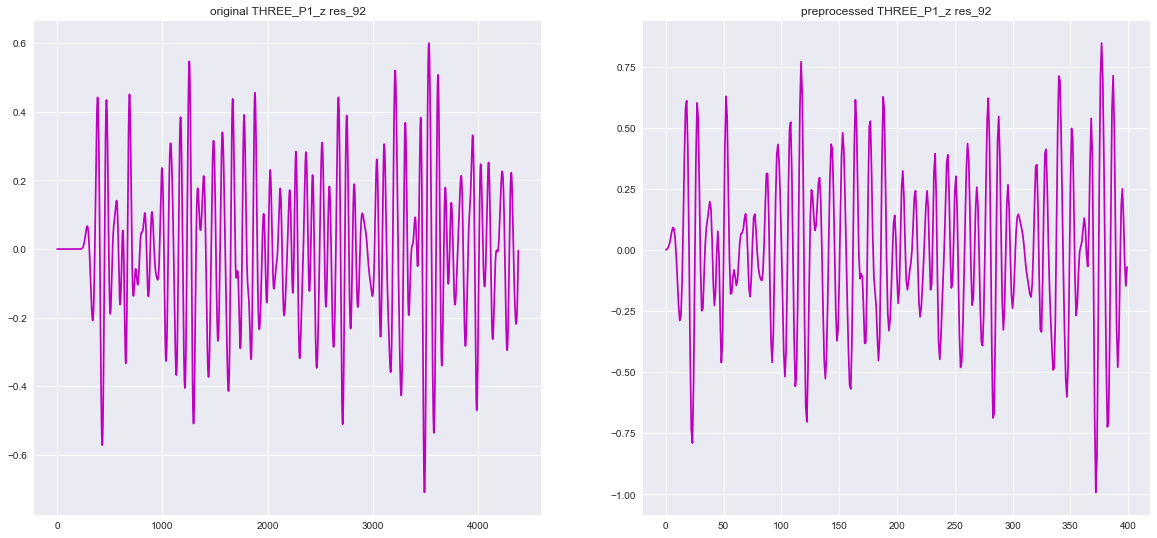

In [18]:
sample=92

Data,l,name=load_db(label_name,typee)
df1=to_df(Data,sample)

plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size':15})
plt.subplot(2,2,1)
plt.title("original {} res_{}".format(name,sample))
plt.plot(df1['port'],color = 'm')



plt.subplot(2,2,2)
plt.title("preprocessed {} res_{}".format(name,sample))
plt.plot(dataframe.iloc[sample-1,:samplerate],color = 'm')
plt.savefig('{}_res_{}.png'.format(name,sample))

# 3d plot

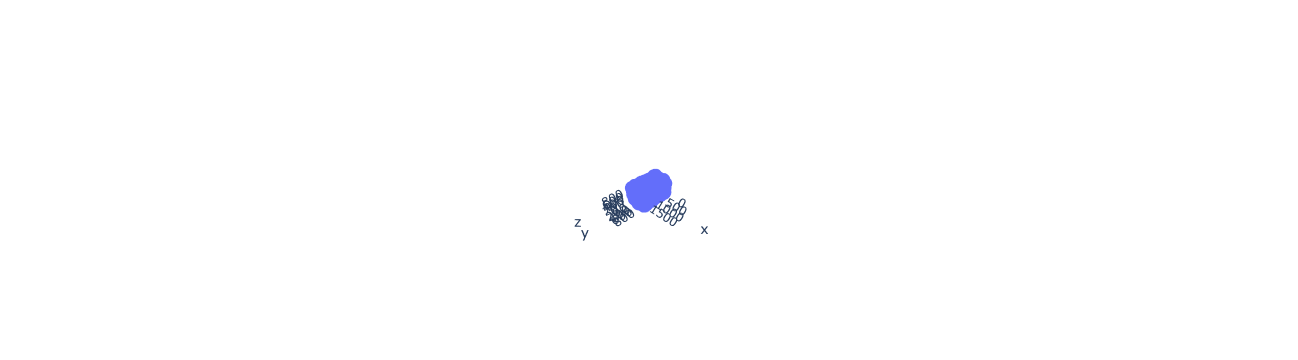

In [27]:
import plotly.graph_objects as go
import numpy as np
fig = go.Figure(data=[go.Scatter3d(x=dataframe["x"], y=dataframe["y"], z=dataframe["z"],mode='markers')])
fig.show()

In [14]:
def pearson_loss(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    # reshape stage
    y_true = K.reshape(y_true, shape=(-1, 224 * 224 * 3))
    y_pred = K.reshape(y_pred, shape=(-1, 224 * 224 * 3))
    # normalizing stage - setting a 0 mean.
    y_true -= y_true.mean(axis=-1)
    y_pred -= y_pred.mean(axis=-1)
    # normalizing stage - setting a 1 variance
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    # final result
    pearson_correlation = K.sum(y_true * y_pred, axis=-1)
    return pearson_correlation


# split labels

In [96]:
#create labels
y = pd.DataFrame({'x':dataframe['x'],
              'y': dataframe['y'],
              'z': dataframe['z']})
dataframe=dataframe.drop(['x', 'y','z'], axis=1)
y

x           y           z
0    1600.186221  780.900357   31.246515
1    1547.653727  522.458703  102.995658
2    1074.709419  563.494303   68.962600
3    1178.553858  100.032474  547.042210
4    1647.025189  192.324801  210.119267
..           ...         ...         ...
995  1588.549939  874.289893  886.463699
996  1402.735170  664.841347  676.497529
997    32.910993   12.471819  581.877918
998  1387.371142  611.209499  794.578809
999  1234.437127  436.952458  460.700941

[1000 rows x 3 columns]

## train 1D data

In [97]:
x_train, x_test, y_train, y_test = train_test_split(dataframe, y,random_state=11, test_size=0.2,shuffle=True)
X_train=x_train.iloc[:,:].values
X_test=x_test.iloc[:,:].values

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

# 1D model

In [98]:
model_name_to_save='final_case_study_three_upscale_z'
samplerate=400
model_name_to_load=model_name_to_save

import os
from pathlib import Path
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

model_name_to_save='1D_'+model_name_to_save
his_file = Path(model_name_to_save)
if his_file.exists():
    print('folder exist')
    his_file = Path("{}/history.csv".format(model_name_to_save))
    if his_file.exists():
      os.remove("{}/history.csv".format(model_name_to_save))
else:
    os.mkdir(model_name_to_save)

data = [x_test, y_test]
testdataframe=pd.concat(data, axis=1)
testdataframe.to_csv("{}/test_{}.csv".format(model_name_to_save,samplerate),index=False)
data = [x_train, y_train]
traindataframe=pd.concat(data, axis=1)
traindataframe.to_csv("{}/train_{}.csv".format(model_name_to_save,samplerate),index=False)    
    
im_shape=(X_train.shape[1],1)
freq_shape=(1)

inputdata=tf.keras.Input(im_shape)
inputfreq=tf.keras.Input(freq_shape)
config1={'model':'cnn','av1':2,'av2':3,'unit1': 32, 'unit2': 256, 'kernel1': 8, 'kernel2': 4,'drop1':0.3,'drop2':0.4, 'dense_size1': 287, 'dense_size2': 179, 'dense_size3': 405,"r1":0.1,"r2":0.1,"r3":0.1,"r4":0.1,"r5":0.1}
config2={'model':'cnn','av1':4,'av2':2,'unit1': 64, 'unit2': 256, 'kernel1': 7, 'kernel2': 10,'drop1':0.1,'drop2':0.2, 'dense_size1': 512, 'dense_size2': 256, 'dense_size3': 512,"r1":0.3,"r2":0.3,"r3":0.4,"r4":0,"r5":0.3}  #new
config3={'model':'snn','dense_size1': 512, 'dense_size2': 512, 'dense_size3': 512,"r3":0.5,"r4":0,"r5":0.4}

def build_1D_model(config):
    if config['model']=='cnn':
        x=layers.GaussianNoise(stddev=0.2)(inputdata) #layer 1
        x=layers.Convolution1D(config['unit1'], (config['kernel1']), activation="relu",kernel_regularizer=l2(config['r1']), input_shape=im_shape )(x)# 7 0.005
        x=layers.AveragePooling1D((config['av1']))(x)
        x=layers.Dropout(config['drop1'])(x) 

        x=layers.Convolution1D(config['unit2'], (config['kernel2']),kernel_regularizer=l2(config['r2']), activation="relu" )(x) #layer 2 #256 3 0.1
        x=layers.AveragePooling1D((config['av2']))(x)
        x=layers.Dropout(config['drop2'])(x)

        x=layers.Flatten()(x) 
    else:
        x=layers.Flatten()(inputdata)
    x=layers.Dense(config['dense_size1'],kernel_regularizer=l2(config['r3']), activation="relu")(x)
    x=layers.Dense(config['dense_size2'],kernel_regularizer=l2(config['r4']), activation="relu")(x)
    x=layers.Dense(config['dense_size3'],kernel_regularizer=l2(config['r5']), activation="relu")(x)
    preoutput=layers.Dense(3)(x)

    model=Model(inputs=inputdata,outputs=preoutput,name=model_name_to_save)


    loss_fn=tf.keras.losses.MeanSquaredError(reduction="auto", name="mse")
    metric=[tf.keras.metrics.MeanSquaredError()]
    #loss_fn=pearson_loss() #custom

    model.compile(optimizer='nadam', loss=loss_fn ,metrics = metric)
    return model 

model=build_1D_model(config2)    
callbacks = [#EarlyStopping(monitor='val_loss', patience=10),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.001,verbose=1),
             tf.keras.callbacks.CSVLogger("{}/history.csv".format(model_name_to_save), append=True),
             ModelCheckpoint(filepath='{}/best_model.h5'.format(model_name_to_save), monitor='val_loss', save_best_only=True)]
model.summary()

Model: "1D_final_case_study_three_upscale_z"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 400, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 394, 64)           512       
_________________________________________________________________
average_pooling1d_4 (Average (None, 98, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 98, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 89, 256)           164096    
_________________________________________________________________
average_pooling1d_5 (Average (N

In [99]:
history=model.fit(X_train,y_train,epochs=200, callbacks=callbacks, batch_size=10,validation_data=(X_test,y_test))
Audio('alarm.mp3',autoplay=True)

Epoch 1/200
80/80 [==============================] - 3s 20ms/step - loss: 179279.0625 - mean_squared_error: 178911.4844 - val_loss: 160100.7969 - val_mean_squared_error: 159771.7344
Epoch 2/200
80/80 [==============================] - 1s 15ms/step - loss: 143063.2969 - mean_squared_error: 142719.1562 - val_loss: 146504.4375 - val_mean_squared_error: 146129.0312
Epoch 3/200
80/80 [==============================] - 1s 15ms/step - loss: 135254.8125 - mean_squared_error: 134833.1406 - val_loss: 124626.1172 - val_mean_squared_error: 124142.1094
Epoch 4/200
80/80 [==============================] - 1s 15ms/step - loss: 114931.3516 - mean_squared_error: 114388.1328 - val_loss: 93864.3281 - val_mean_squared_error: 93255.1562
Epoch 5/200
80/80 [==============================] - 1s 15ms/step - loss: 92274.5312 - mean_squared_error: 91624.2578 - val_loss: 86724.6016 - val_mean_squared_error: 86042.1328
Epoch 6/200
80/80 [==============================] - 1s 15ms/step - loss: 78137.9688 - mean_squa

# K-FOLD cross validation

In [27]:
from sklearn.model_selection import KFold
import math
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
acc_per_fold,loss_per_fold,corelations=[],[],[]
for train, test in kfold.split(inputs, targets):
    model=build_1D_model(config2)
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=10,
              epochs=100)
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    
    c,c2,index=0,0,0
    errors={}
    validation={}
    for i in model.predict(inputs[test]):
        x,y,z=i
        x2,y2,z2=targets[test][c2]
        validation[c]=[x,y,z,index,'predict']
        c+=1
        validation[c]=[x2,y2,z2,index,'real']
        c+=1
        c2+=1
        index+=1
        errors[c]=math.sqrt((1/3)*((x2-x)**2+(y2-y)**2+(z2-z)**2))

    validation=pd.DataFrame.from_dict(validation, orient='index',columns=['x','y','z','index','kind'])
    x=np.corrcoef(validation[validation['kind'] == 'predict']['x'],validation[validation['kind'] == 'real']['x'])[0][1]
    y=np.corrcoef(validation[validation['kind'] == 'predict']['y'],validation[validation['kind'] == 'real']['y'])[0][1]
    z=np.corrcoef(validation[validation['kind'] == 'predict']['z'],validation[validation['kind'] == 'real']['z'])[0][1]
    print("R:\n",x,y,z)
    corelations.append([x,y,z])
    # Increase fold number
    fold_no = fold_no + 1
    
Audio('alarm.mp3',autoplay=True)    

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
180/180 [==============================] - 11s 47ms/step - loss: 34180.4141 - mean_squared_error: 33853.2148
Epoch 2/100
180/180 [==============================] - 8s 46ms/step - loss: 26950.8457 - mean_squared_error: 26575.1133
Epoch 3/100
180/180 [==============================] - 8s 46ms/step - loss: 21453.8066 - mean_squared_error: 20934.3340
Epoch 4/100
180/180 [==============================] - 9s 48ms/step - loss: 18772.4746 - mean_squared_error: 18151.1836
Epoch 5/100
180/180 [==============================] - 9s 47ms/step - loss: 17545.8867 - mean_squared_error: 16866.4707
Epoch 6/100
180/180 [==============================] - 8s 46ms/step - loss: 16220.5645 - mean_squared_error: 15498.1729
Epoch 7/100
180/180 [==============================] - 9s 50ms/step - loss: 15654.4932 - mean_squared_error: 14896.8721
Epoch 8/100
180/180 [==============================] - 9s 49ms

In [28]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - MSE: {acc_per_fold[i]}%')
    print(f'> R:{corelations[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> MSE: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> R: {np.mean(corelations)} (+- {np.std(corelations)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 11433.837890625 - MSE: 10042.265625%
> R:[0.9696407182394786, 0.48377705315889113, 0.4295973877885538]
------------------------------------------------------------------------
> Fold 2 - Loss: 10122.7470703125 - MSE: 8743.0810546875%
> R:[0.9659383385683495, 0.48556625156907557, 0.5668280135803098]
------------------------------------------------------------------------
> Fold 3 - Loss: 8266.4677734375 - MSE: 6864.9326171875%
> R:[0.9811652113278942, 0.6482988406204699, 0.5919294591649357]
------------------------------------------------------------------------
> Fold 4 - Loss: 10105.1962890625 - MSE: 8703.568359375%
> R:[0.9633396932024848, 0.513907571349001, 0.5479065479076851]
------------------------------------------------------------------------
> Fold 5 - Loss: 11287.8359375 - MSE: 9983.837890625%
> R:[0

# grid search 1D

In [49]:
def build_model(hp):
    unit1 = hp.Choice('unit1', values=[64,128,256,512,1024])
    unit12 = hp.Choice('kernel', values=[2,4,5,6,7,8,9,10])
    unit13 = hp.Choice('pol', values=[2,4,5,6,7,8,9,10])
    unit14 = hp.Choice('drop', values=[0.1,0.2,0.3])
    
    model = tf.keras.Sequential()
    model.add( layers.InputLayer(input_shape=im_shape))
        
    model.add(
            layers.GaussianNoise(stddev=0.2)
          )

    model.add(
        layers.Convolution1D(64, (7), activation="relu",kernel_regularizer=l2(0.3), input_shape=im_shape )
    )
    model.add(
          layers.AveragePooling1D((4))
    )       
    model.add(
          layers.Dropout(0.1)
          )

    model.add(
        layers.Convolution1D(256, (10),kernel_regularizer=l2(0.3), activation="relu" )
    )
    model.add(
          layers.AveragePooling1D((2))
    )  
    model.add(
        layers.Dropout(0.2)
    )
    
    model.add(
        layers.Convolution1D(unit1, (unit12),kernel_regularizer=l2(0.3), activation="relu" )
    )
    model.add(
          layers.AveragePooling1D((unit13))
    )  
    model.add(
        layers.Dropout(unit14)
    )
    
    model.add(
      layers.Flatten()
    )
    model.add(
        layers.Dense(512,kernel_regularizer=l2(0.4), activation="relu")
    )
    model.add(
        layers.Dense(256,kernel_regularizer=l2(0.0), activation="relu")
    )
    model.add(
        layers.Dense(512,kernel_regularizer=l2(0.3), activation="relu")
    )
    model.add(
        layers.Dense(3)
    )    
    model.compile(
        optimizer='nadam', loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mse") ,metrics = [tf.keras.metrics.MeanSquaredError()]
    )
    return model

callbacks = [#EarlyStopping(monitor='val_loss', patience=10),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.001,verbose=1),
             #tf.keras.callbacks.CSVLogger("{}/history.csv".format(model_name_to_save), append=True),
            # ModelCheckpoint(filepath='{}/best_model.h5'.format(model_name_to_save), monitor='val_loss', save_best_only=True)
]

In [50]:
from keras_tuner import RandomSearch
trials=15
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=trials,
    executions_per_trial=2,
    overwrite=False,
    directory="1d_tune",
    project_name="tuned_model",
)

In [51]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
unit1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512, 1024], 'ordered': True}
kernel (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4, 5, 6, 7, 8, 9, 10], 'ordered': True}
pol (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4, 5, 6, 7, 8, 9, 10], 'ordered': True}
drop (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}


In [52]:
tuner.search(X_train, y_train, epochs=20,batch_size=10,callbacks=callbacks, validation_data=(X_test, y_test))
Audio('alarm.mp3',autoplay=True)

Trial 14 Complete [00h 04m 34s]
val_mean_squared_error: 37340.9609375

Best val_mean_squared_error So Far: 37340.9609375
Total elapsed time: 01h 22m 11s

Search: Running Trial #15

Hyperparameter    |Value             |Best Value So Far 
unit1             |64                |64                
kernel            |8                 |10                
pol               |6                 |10                
drop              |0.1               |0.3               

Epoch 1/20
171/171 [==============================] - 10s 43ms/step - loss: 44046.9805 - mean_squared_error: 43846.6055 - val_loss: 41568.8750 - val_mean_squared_error: 41403.1367
Epoch 2/20
171/171 [==============================] - 6s 37ms/step - loss: 38937.2656 - mean_squared_error: 38776.7656 - val_loss: 41184.9141 - val_mean_squared_error: 41029.0391
Epoch 3/20
171/171 [==============================] - 6s 37ms/step - loss: 38812.7969 - mean_squared_error: 38659.8984 - val_loss: 44493.7305 - val_mean_squared_error: 44342.

KeyboardInterrupt: 

In [88]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'av1': 4, 'av2': 2}


In [90]:
trials=15
tuner.results_summary(trials)

Results summary
Results in 1d_tune\tuned_model
Showing 15 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
av1: 4
av2: 2
Score: 5222.003662109375
Trial summary
Hyperparameters:
av1: 4
av2: 4
Score: 5224.31103515625
Trial summary
Hyperparameters:
av1: 5
av2: 3
Score: 5643.284423828125
Trial summary
Hyperparameters:
av1: 6
av2: 2
Score: 5968.892822265625
Trial summary
Hyperparameters:
av1: 2
av2: 5
Score: 6032.020751953125
Trial summary
Hyperparameters:
av1: 2
av2: 2
Score: 6136.34375
Trial summary
Hyperparameters:
av1: 7
av2: 2
Score: 6178.314453125
Trial summary
Hyperparameters:
av1: 5
av2: 4
Score: 6283.4765625
Trial summary
Hyperparameters:
av1: 3
av2: 7
Score: 6535.24072265625
Trial summary
Hyperparameters:
av1: 1
av2: 4
Score: 6844.954345703125
Trial summary
Hyperparameters:
av1: 1
av2: 3
Score: 6981.42529296875
Trial summary
Hyperparameters:
av1: 1
av2: 5
Score: 7010.64453125
Trial summary
Hyperparameters:
av1: 6
av2: 7
Score: 86

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)

# save model architecture

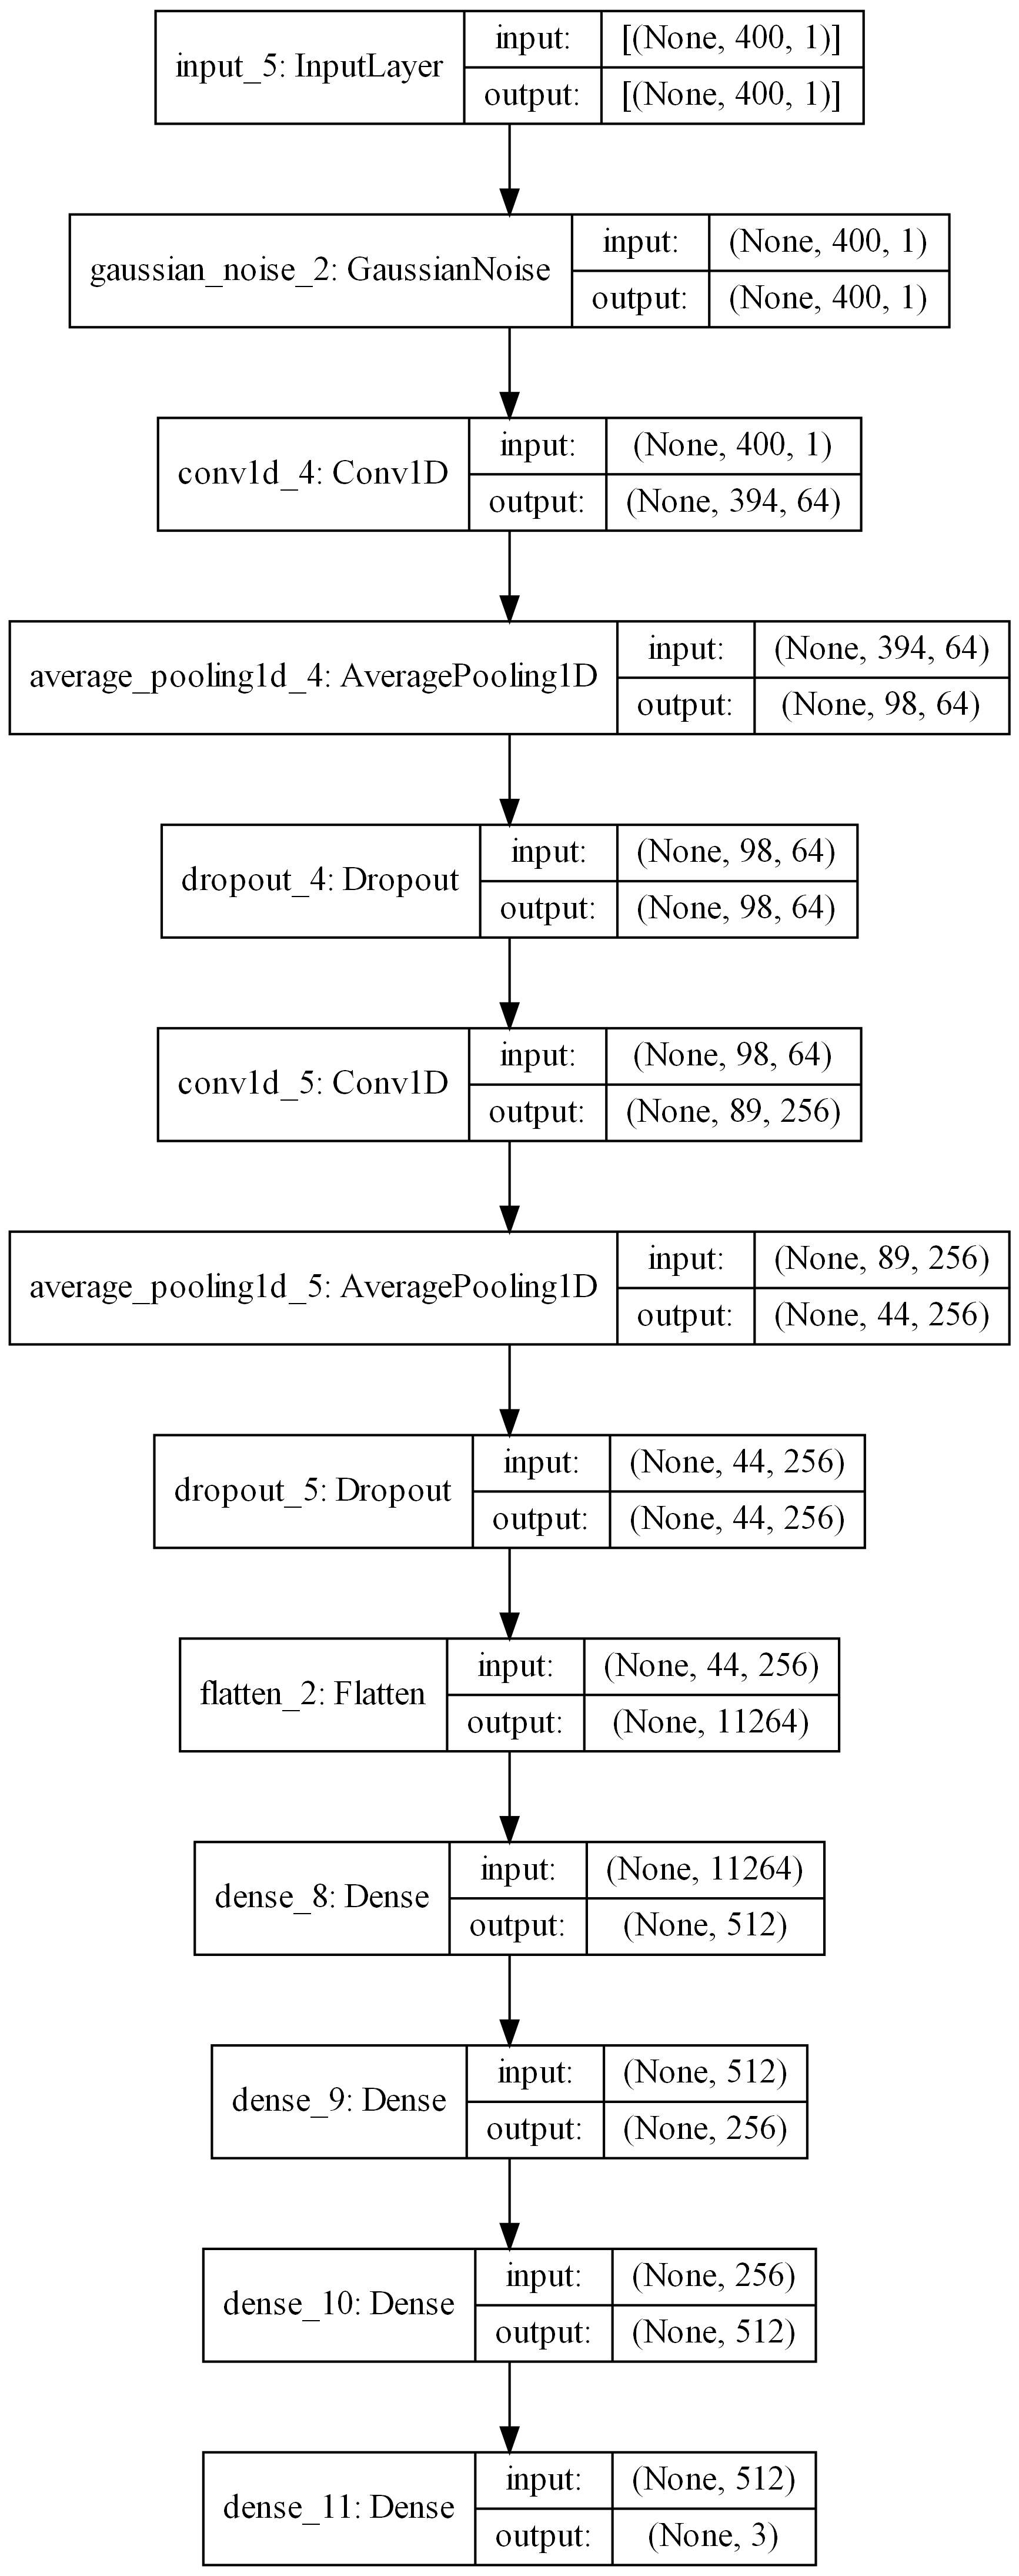

In [100]:
tf.keras.utils.plot_model(model,to_file="{}/architecture.png".format(model_name_to_save),show_layer_names=True,dpi=300,show_shapes=True,expand_nested=True)

# plot history

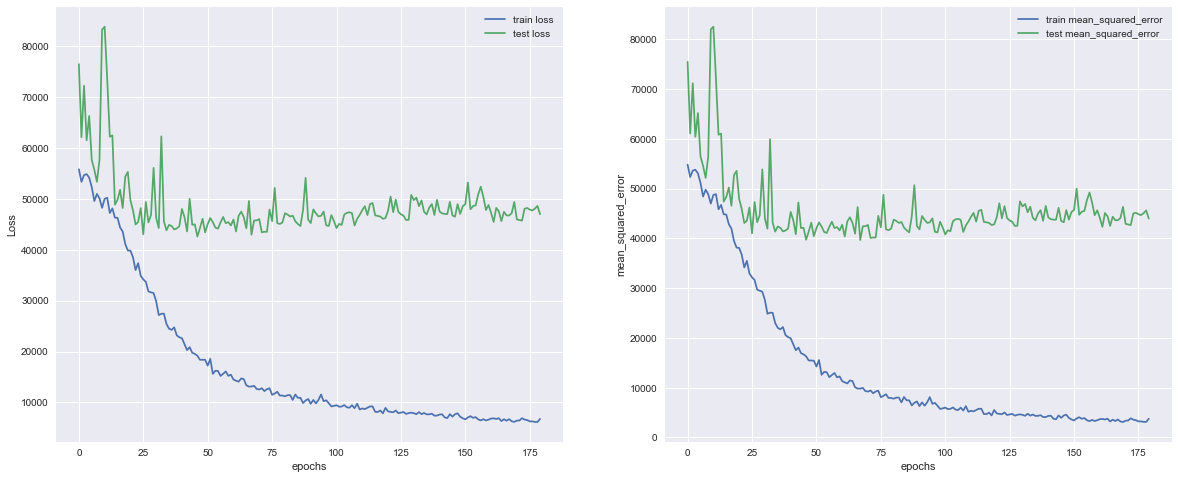

In [101]:
plt.figure(1,figsize=(20,8))
plt.subplot(1,2,1)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'][20:], label = 'train loss')
plt.plot(history.history['val_loss'][20:], label = 'test loss')
try:
    plt.plot(history.history['X_loss'][20:], label = 'X train loss')
    plt.plot(history.history['val_X_loss'][20:], label = 'X test loss')
    plt.plot(history.history['Y_loss'][20:], label = 'Y train loss')
    plt.plot(history.history['val_Y_loss'][20:], label = 'Y test loss')
    plt.plot(history.history['Z_loss'][20:], label = 'Z train loss')
    plt.plot(history.history['val_Z_loss'][20:], label = 'Z test loss')
except:
    pass
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("epochs")
try:
    plt.ylabel('mean_squared_error')
    plt.plot(history.history['X_mean_squared_error'][20:], label = 'X train mean_squared_error')
    plt.plot(history.history['val_X_mean_squared_error'][20:], label = 'X test mean_squared_error' )
    plt.plot(history.history['Y_mean_squared_error'][20:], label = 'Y train mean_squared_error')
    plt.plot(history.history['val_Y_mean_squared_error'][20:], label = 'Y test mean_squared_error' )
    plt.plot(history.history['Z_mean_squared_error'][20:], label = 'Z train mean_squared_error')
    plt.plot(history.history['val_Z_mean_squared_error'][20:], label = 'Z test mean_squared_error' )
except:
    plt.ylabel('mean_squared_error')
    plt.plot(history.history['mean_squared_error'][20:], label = 'train mean_squared_error')
    plt.plot(history.history['val_mean_squared_error'][20:], label = 'test mean_squared_error' )
plt.grid(True)
plt.legend()
plt.savefig('{}/graph.png'.format(model_name_to_save))

# evaluate on test data

In [14]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=4,verbose=2)
print("Test loss:", results[0])
print("Test mean_squared_error:", results[1])

Evaluate on test data
50/50 - 0s - loss: 61274.9492 - mean_squared_error: 58873.1016
Test loss: 61274.94921875
Test mean_squared_error: 58873.1015625


# save model

In [104]:
model.save_weights('{}/weights_only.h5'.format(model_name_to_save)) #1 reserved
model.save('{}/model.h5'.format(model_name_to_save),include_optimizer=True,overwrite=True)

# save hyperparameters

In [105]:
model_config = model.get_config()['layers']
text=''
for layer in model_config:
    classname=layer['class_name']
    try:
        name=layer['name']
    except:
        name=layer['config']['name']
    config = layer['config']
    print('-'*20,'(',classname,'\t',name,')','-'*20)
    text+='-'*20+'('+classname+'\t'+name+')'+'-'*20+'\n'
    for key,value in config.items():    
        if value==None or key=='name' or key=='trainable' or key=='dtype':
            continue
        print(key,'\t',value)
        text+=key+'\t'+str(value)+'\n'
f=open('{}/hyperparameters.txt'.format(model_name_to_save),'w')  
f.write(text)
f.close()

-------------------- ( InputLayer 	 input_5 ) --------------------
batch_input_shape 	 (None, 400, 1)
sparse 	 False
ragged 	 False
-------------------- ( GaussianNoise 	 gaussian_noise_2 ) --------------------
stddev 	 0.2
-------------------- ( Conv1D 	 conv1d_4 ) --------------------
batch_input_shape 	 (None, 400, 1)
filters 	 64
kernel_size 	 (7,)
strides 	 (1,)
padding 	 valid
data_format 	 channels_last
dilation_rate 	 (1,)
groups 	 1
activation 	 relu
use_bias 	 True
kernel_initializer 	 {'class_name': 'GlorotUniform', 'config': {'seed': None}}
bias_initializer 	 {'class_name': 'Zeros', 'config': {}}
kernel_regularizer 	 {'class_name': 'L2', 'config': {'l2': 0.30000001192092896}}
-------------------- ( AveragePooling1D 	 average_pooling1d_4 ) --------------------
strides 	 (4,)
pool_size 	 (4,)
padding 	 valid
data_format 	 channels_last
-------------------- ( Dropout 	 dropout_4 ) --------------------
rate 	 0.1
-------------------- ( Conv1D 	 conv1d_5 ) --------------------
f

# load model

## best

In [236]:
samplerate=400
label_name="THREE_UPSCALE"
model_name_to_load='../../1D_final_case_study_three_upscale_z'
model_name_to_save="../logs/1D_final_case_study_three_upscale_z"                #model_name_to_load
model=tf.keras.models.load_model('{}/best_model.h5'.format(model_name_to_load))
model.summary()

Model: "1D_final_case_study_three_upscale_z"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 400, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 394, 64)           512       
_________________________________________________________________
average_pooling1d_4 (Average (None, 98, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 98, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 89, 256)           164096    
_________________________________________________________________
average_pooling1d_5 (Average (N

In [60]:
label_name="THREE_UPSCALE"
model_name_to_load='1D_final_case_study_three_upscale_z'
model_name_to_save=model_name_to_load
model=tf.keras.models.load_model('{}/model.h5'.format(model_name_to_load))
model.summary()

OSError: SavedModel file does not exist at: 1D_final_case_study_three_upscale_z/model.h5\{saved_model.pbtxt|saved_model.pb}

## load train and test db

In [237]:
testdataframe=pd.read_csv ("{}/test_{}.csv".format(model_name_to_load,samplerate)) 
traindataframe=pd.read_csv ("{}/train_{}.csv".format(model_name_to_load,samplerate)) 
y_test = pd.DataFrame({'x':testdataframe['x'],
              'y': testdataframe['y'],
              'z': testdataframe['z']})
X_test=testdataframe.drop(['x', 'y','z'], axis=1)
y_train = pd.DataFrame({'x':traindataframe['x'],
              'y': traindataframe['y'],
              'z': traindataframe['z']})
X_train=traindataframe.drop(['x', 'y','z'], axis=1)

## get parameters

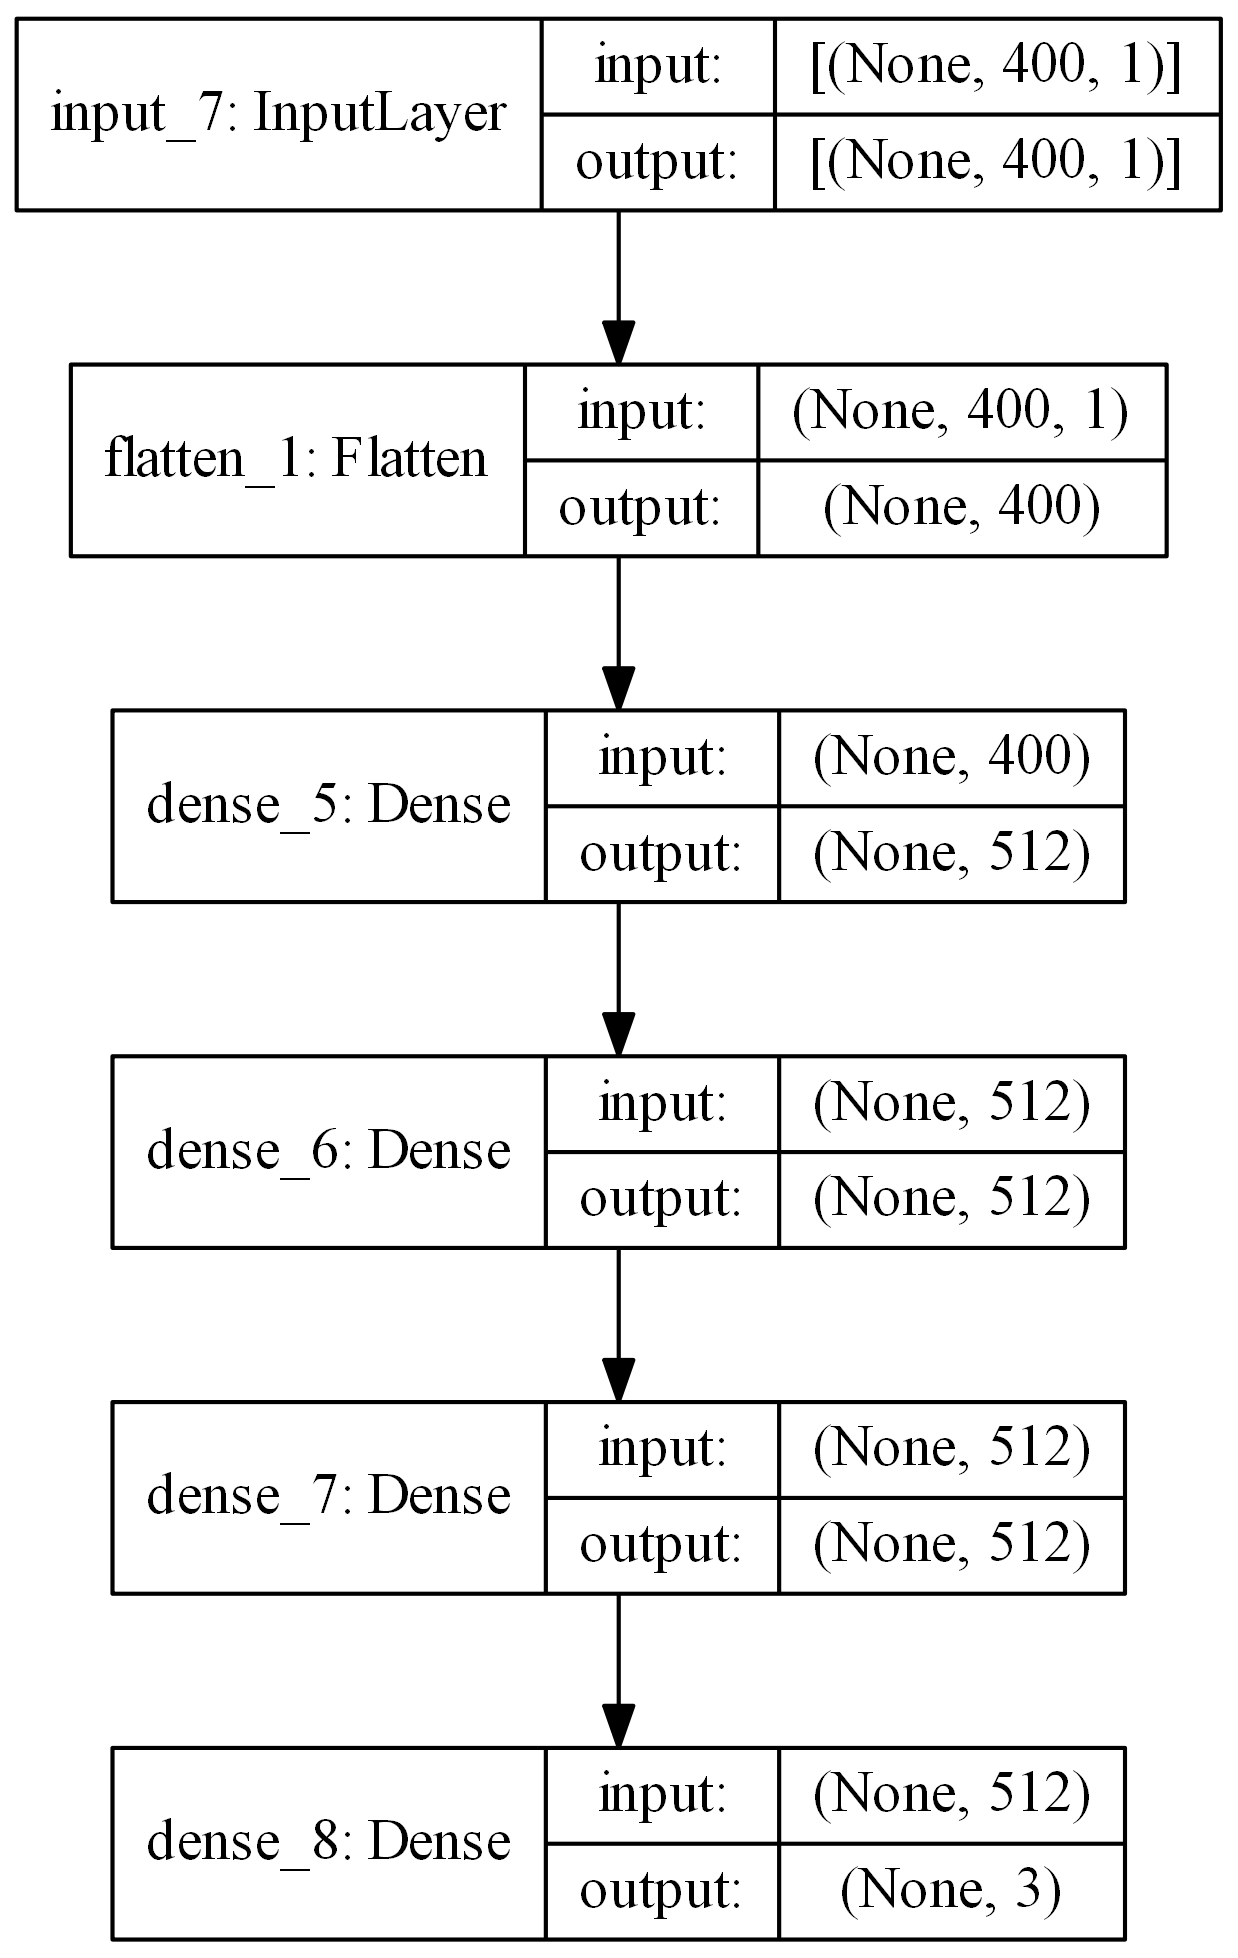

In [50]:
tf.keras.utils.plot_model(model,to_file="{}/architecture.png".format(model_name_to_save),show_layer_names=True,dpi=300,show_shapes=True,expand_nested=True)

## train history

In [238]:
import csv
import pathlib
from pprint import pprint
his=pd.read_csv('{}/history.csv'.format(model_name_to_load))
print("total epochs:",len(his['epoch']))
his

total epochs: 200


epoch           loss     lr  mean_squared_error       val_loss  \
0        0  179279.062500  0.001       178911.484375  160100.796875   
1        1  143063.296875  0.001       142719.156250  146504.437500   
2        2  135254.812500  0.001       134833.140625  124626.117188   
3        3  114931.351562  0.001       114388.132812   93864.328125   
4        4   92274.531250  0.001        91624.257812   86724.601562   
..     ...            ...    ...                 ...            ...   
195    195    6284.256836  0.001         3227.518799   47907.914062   
196    196    6275.463867  0.001         3229.407715   47724.156250   
197    197    6181.745117  0.001         3149.053223   48090.890625   
198    198    6152.321777  0.001         3132.815918   48627.378906   
199    199    6765.431152  0.001         3760.916992   46991.359375   

     val_mean_squared_error  
0             159771.734375  
1             146129.031250  
2             124142.109375  
3              93255.156250  
4              86042.132812  
..                      ...  
195            44855.156250  
196            44683.050781  
197            45066.550781  
198            45617.203125  
199            43983.960938  

[200 rows x 6 columns]

## plot trained model history

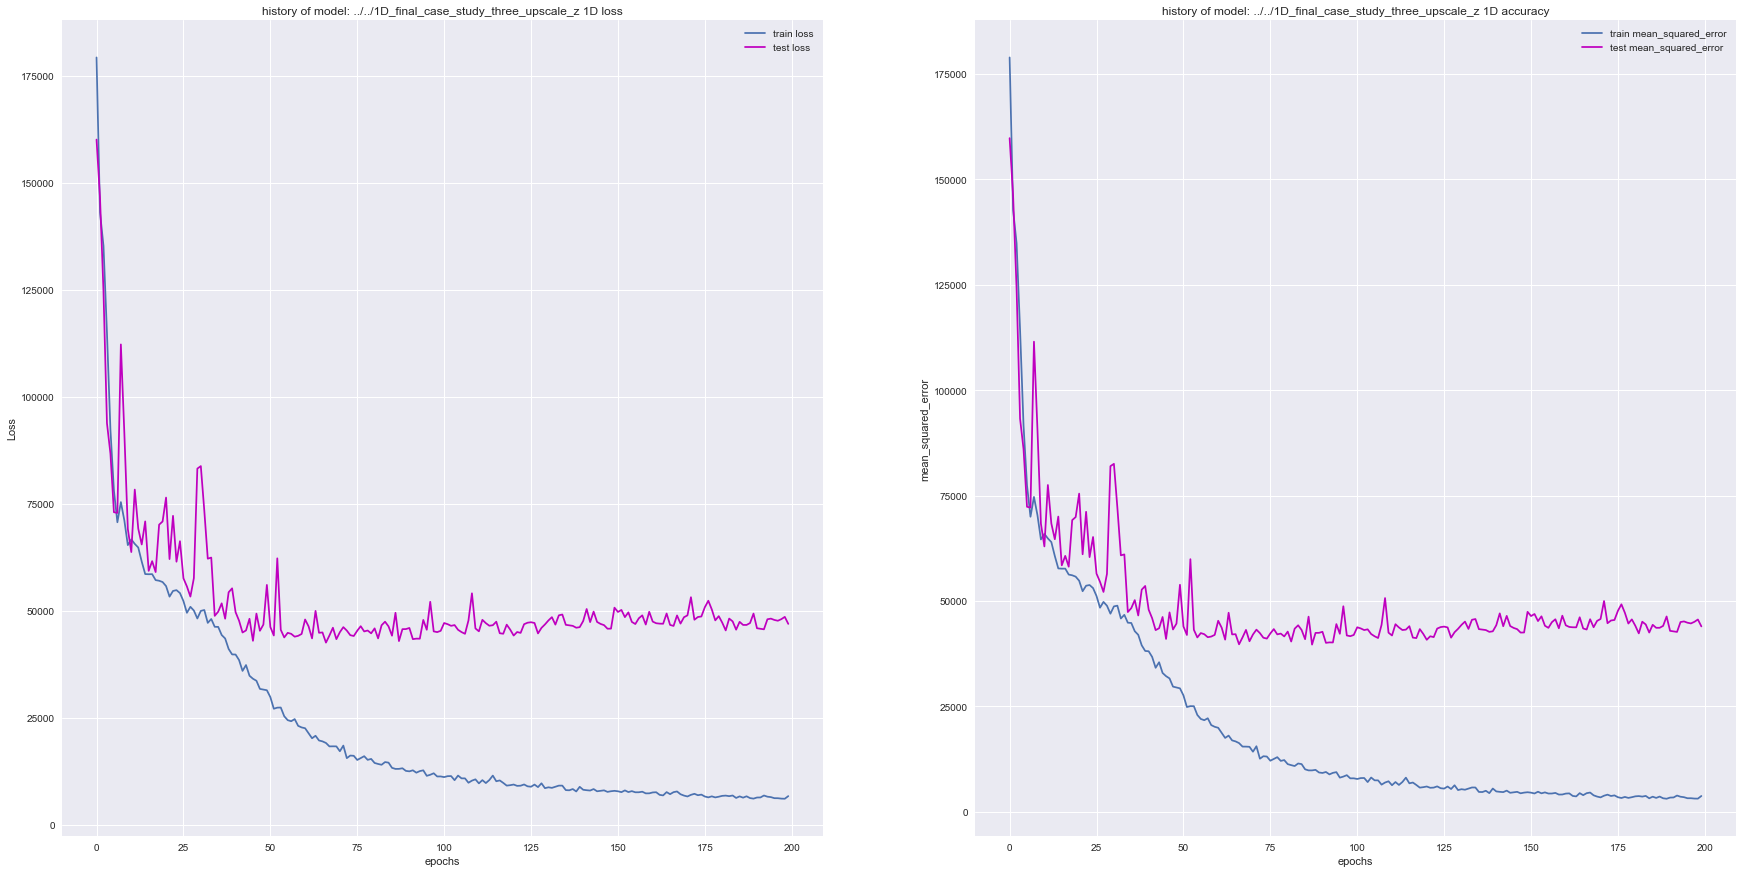

In [239]:
plt.figure(1,figsize=(30,15))
plt.subplot(1,2,1)
plt.title("history of model: {} 1D".format(model_name_to_load)+ " loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
try:
    plt.plot(his['X_loss'][20:], label = 'X train loss')
    plt.plot(his['val_X_loss'][20:], label = 'X test loss')
    plt.plot(his['Y_loss'][20:], label = 'Y train loss')
    plt.plot(his['val_Y_loss'][20:], label = 'Y test loss')
    plt.plot(his['Z_loss'][20:], label = 'Z train loss')
    plt.plot(his['val_Z_loss'][20:], label = 'Z test loss')
except:
    plt.plot(his['loss'], label = 'train loss')
    plt.plot(his['val_loss'], label = 'test loss',color='m')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.title("history of model: {} 1D".format(model_name_to_load)+ " accuracy")
plt.xlabel("epochs")
plt.ylabel('mean_squared_error')
try:
    plt.plot(his['X_mean_squared_error'][20:], label = 'X train mean_squared_error')
    plt.plot(his['val_X_mean_squared_error'][20:], label = 'X test mean_squared_error' )
    plt.plot(his['Y_mean_squared_error'][20:], label = 'Y train mean_squared_error')
    plt.plot(his['val_Y_mean_squared_error'][20:], label = 'Y test mean_squared_error' )
    plt.plot(his['Z_mean_squared_error'][20:], label = 'Z train mean_squared_error')
    plt.plot(his['val_Z_mean_squared_error'][20:], label = 'Z test mean_squared_error' )
except:
    plt.plot(his['mean_squared_error'], label = 'train mean_squared_error')
    plt.plot(his['val_mean_squared_error'], label = 'test mean_squared_error',color='m')
plt.grid(True)
plt.legend()
plt.savefig('{}/graph.png'.format(model_name_to_save))

# test

## normal

In [240]:
import math
import statistics

c,c2,index=0,0,0
errors={}
validation={}
poly_space=[]

if label_name=="THREE_UPSCALE":
    Xconstant=1000
    Zconstant=500
else:    
    Xconstant=500
    Zconstant=250
    
if label_name=="THREE_RESHAPE" or label_name=="THREE_UPSCALE": 
    Yconstant=500
else:    
    Yconstant=250   
    
    
for i in model.predict(X_test):
    x,y,z=i
    x2,y2,z2=y_test.to_numpy()[c2]
    validation[c]=[x,y,z,index,'predict']
    c+=1
    validation[c]=[x2,y2,z2,index,'actual']
    poly_space.append(math.sqrt((x2-Xconstant)**2+(y2-Yconstant)**2+(z2-Zconstant)**2))
    c+=1
    c2+=1
    index+=1
    errors[c]=math.sqrt((1/3)*((x2-x)**2+(y2-y)**2+(z2-z)**2))

validation=pd.DataFrame.from_dict(validation, orient='index',columns=['x','y','z','index','kind'])
validation.to_csv("{}/prediction_per_actual.csv".format(model_name_to_save),index=False)

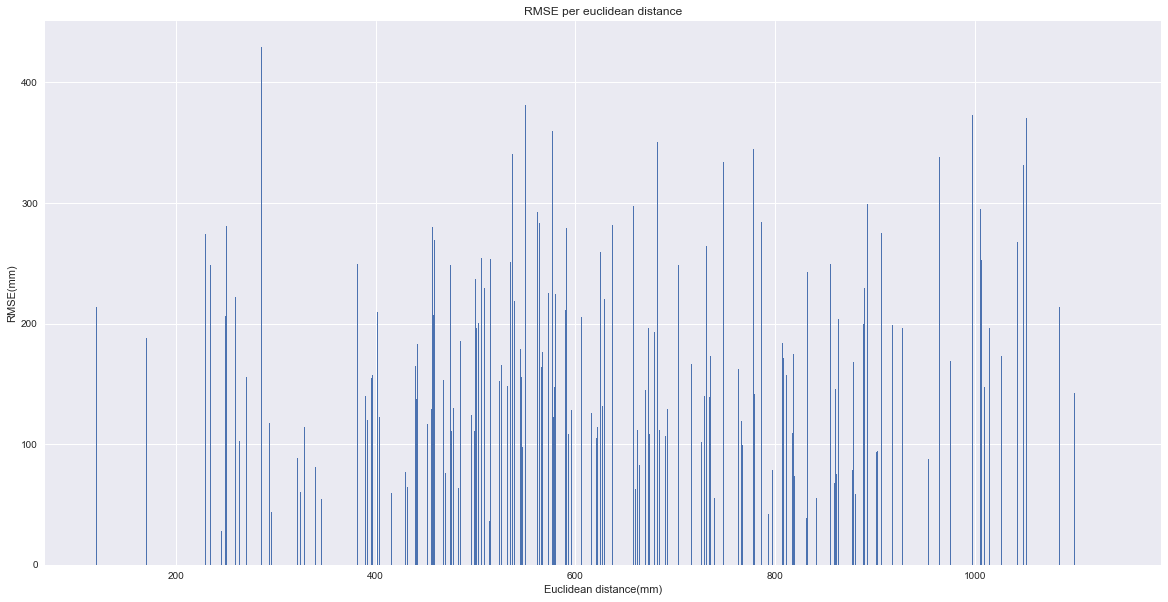

In [241]:
plt.figure(1,figsize=(20,10))
plt.title("RMSE per euclidean distance")

plt.bar(poly_space,list(errors.values()))
plt.ylabel("RMSE(mm)")
plt.xlabel("Euclidean distance(mm)")

plt.savefig('{}/Euclidean_distance.png'.format(model_name_to_save))

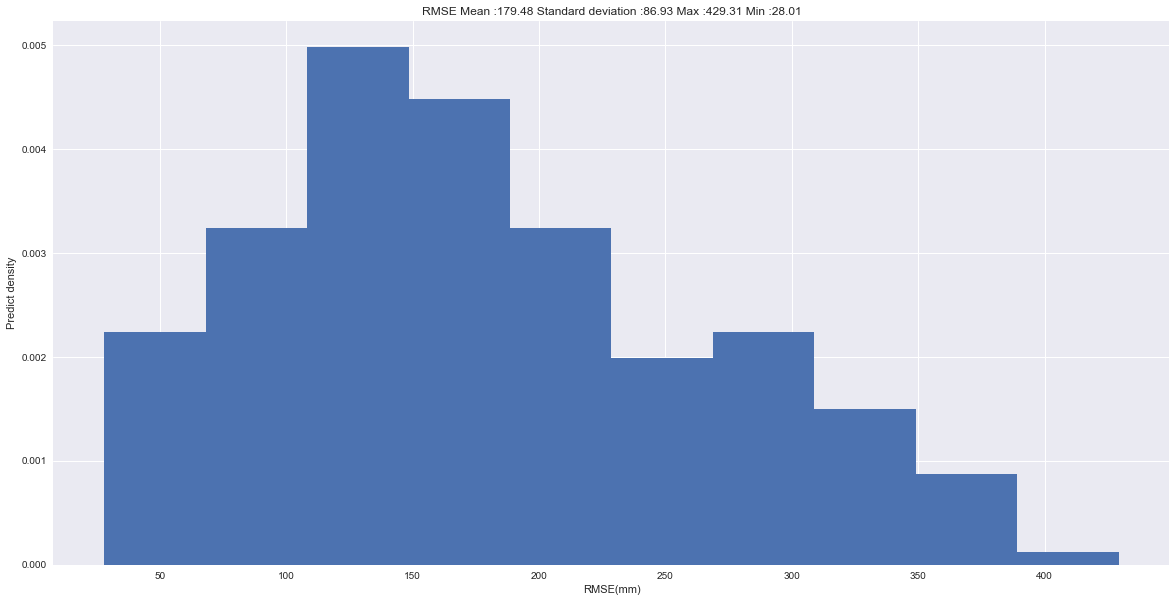

In [242]:
plt.figure(1,figsize=(20,10))
values=list(errors.values())
m=round(np.mean(values),2)
sd=round(statistics.stdev(values),2)
maximum=round(np.max(values),2)
minimum=round(np.min(values),2)
plt.title("RMSE Mean :{} Standard deviation :{} Max :{} Min :{}".format(m,sd,maximum,minimum))

plt.hist(values, density=True)
plt.ylabel("Predict density")
plt.xlabel("RMSE(mm)")

plt.savefig('{}/losses.png'.format(model_name_to_save))

In [194]:
validation[0:10]

x           y           z  index     kind
0  541.857849  583.333557  265.260895      0  predict
1  563.576206  734.832614  275.994877      0   actual
2  699.128845  671.419373   90.566368      1  predict
3  751.729149  609.637149  134.817187      1   actual
4  401.996490  668.409363  107.471237      2  predict
5  266.500542  705.464868  106.596377      2   actual
6  638.300720  170.368744  190.200119      3  predict
7  703.281542   87.769942  180.555739      3   actual
8  398.074249  647.146118  347.299164      4  predict
9  435.687334  835.154943  281.384829      4   actual

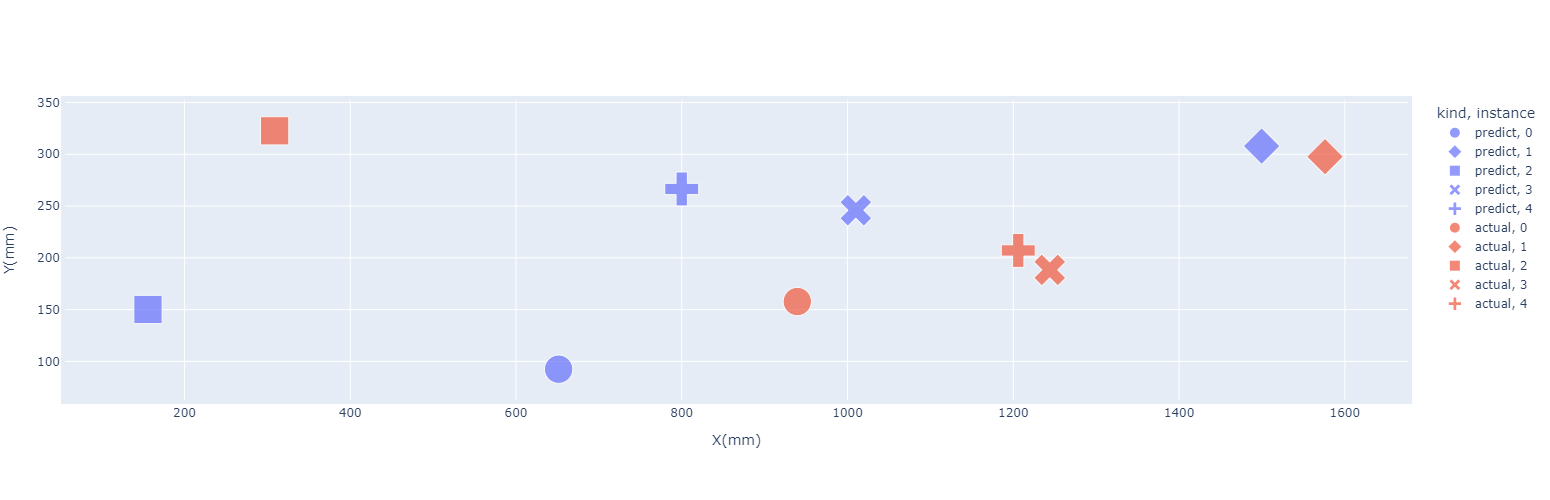

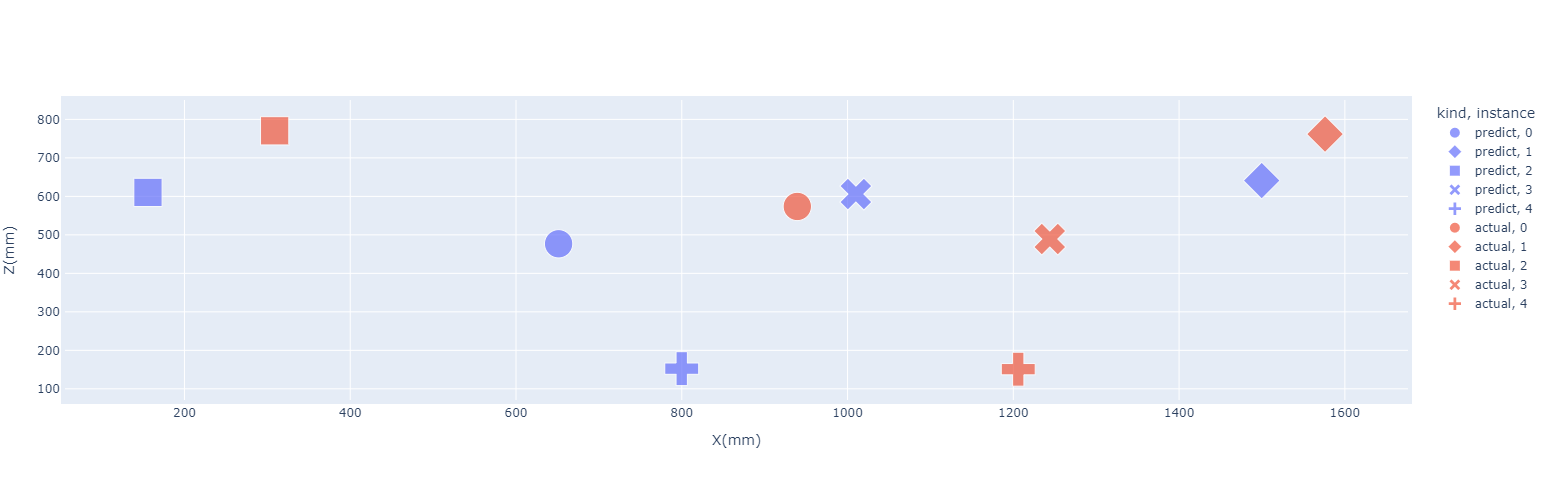

In [243]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


fig=px.scatter(data_frame = validation[0:10]
            ,x = 'x'
            ,y = 'y'
            ,color = 'kind'
            ,symbol="index"  
            ,size=[10,10,10,10,10,10,10,10,10,10] 
            ,labels={
                     "x": "X(mm)",
                     "y": "Y(mm)",
                     "kind": "kind",
                     "index":"instance"
                 },
           )
fig.update_layout(
    autosize=True,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="white",
)

fig.show()
fig.write_image("{}/YX.png".format(model_name_to_save))
fig=px.scatter(data_frame = validation[0:10]
            ,x = 'x'
            ,y = 'z'
            ,color = 'kind'
            ,symbol="index" 
            ,size=[10,10,10,10,10,10,10,10,10,10] 
            ,labels={
                     "x": "X(mm)",
                     "z": "Z(mm)",
                     "kind": "kind",
                     "index":"instance"
                 },
           )
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="white",
)
fig.show()
fig.write_image("{}/ZX.png".format(model_name_to_save))

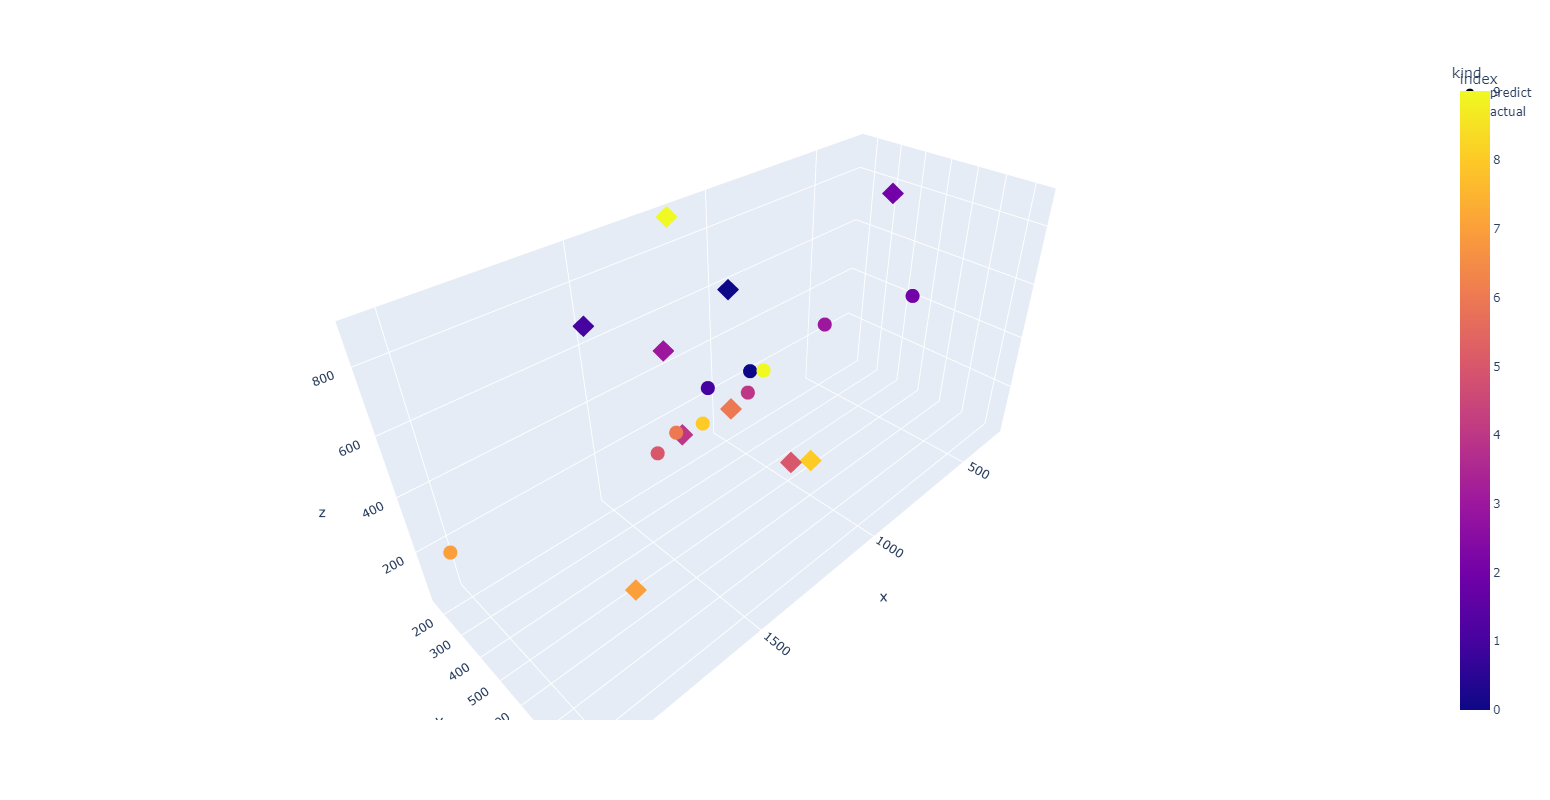

In [226]:
import plotly.express as px
fig = px.scatter_3d(validation[0:20],x="x", y="y", z="z",color='index', symbol='kind')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

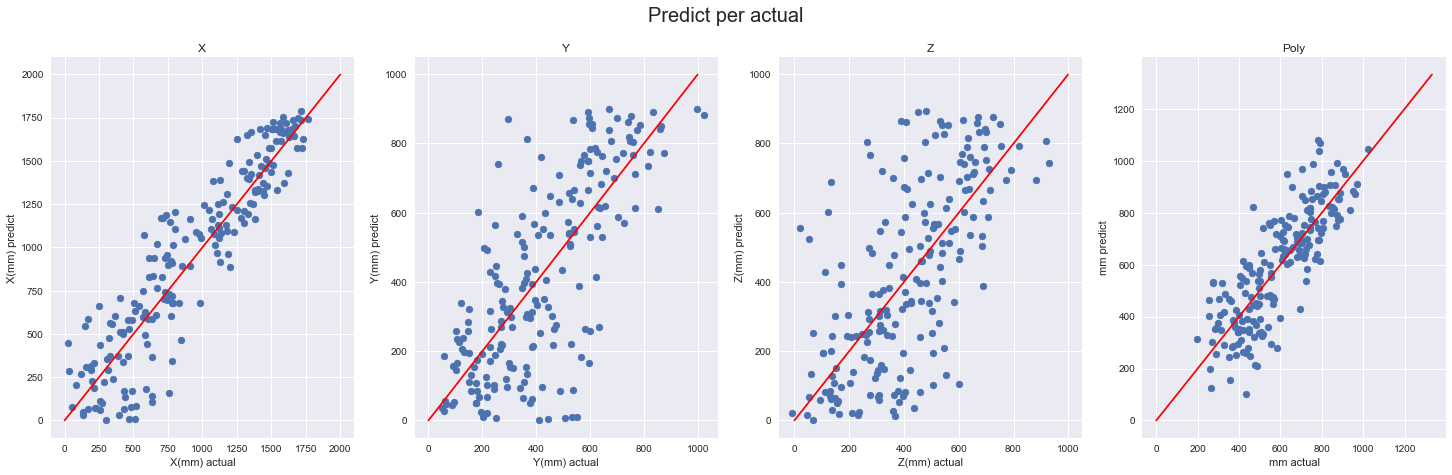

In [244]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(25,7))
plt.suptitle( 'Predict per actual', fontsize=20)
plt.rcParams.update({'font.size':15})

plt.subplot(1,4,1)
plt.title('X')
plt.ylabel("X(mm) predict")
plt.xlabel("X(mm) actual")
plt.scatter(validation[validation['kind'] == 'predict']['x'] , validation[validation['kind'] == 'actual']['x'])
if label_name=="THREE_UPSCALE":
    Xconstant=2000
else:    
    Xconstant=1000
plt.plot(range(0,Xconstant),range(0,Xconstant),"r")
plt.grid(True)

plt.subplot(1,4,2)
plt.title('Y')
plt.ylabel("Y(mm) predict")
plt.xlabel("Y(mm) actual")
plt.scatter(validation[validation['kind'] == 'predict']['y'] , validation[validation['kind'] == 'actual']['y'])
if label_name=="THREE_RESHAPE" or label_name=="THREE_UPSCALE":
    Yconstant=1000  
else:    
    Yconstant=500
plt.plot(range(0,Yconstant),range(0,Yconstant),"r")
plt.grid(True)

plt.subplot(1,4,3)
plt.title('Z')
plt.ylabel("Z(mm) predict")
plt.xlabel("Z(mm) actual")
plt.scatter(validation[validation['kind'] == 'predict']['z'], validation[validation['kind'] == 'actual']['z'])
if label_name=="THREE_UPSCALE":
    Zconstant=1000 
else:    
    Zconstant=500
plt.plot(range(0,Zconstant),range(0,Zconstant),"r")
plt.grid(True)

plt.subplot(1,4,4)
plt.title('Poly')
plt.ylabel("mm predict")
plt.xlabel("mm actual")
plt.scatter((validation[validation['kind'] == 'predict']['x']+validation[validation['kind'] == 'predict']['y']+validation[validation['kind'] == 'predict']['z'])/3, (validation[validation['kind'] == 'actual']['x']+validation[validation['kind'] == 'actual']['y']+validation[validation['kind'] == 'actual']['z'])/3)
if label_name=="THREE_UPSCALE":
    Zconstant=1000 
else:    
    Zconstant=500
plt.plot(range(0,int((Xconstant+Yconstant+Zconstant)/3)),range(0,int((Xconstant+Yconstant+Zconstant)/3)),"r")
plt.grid(True)

plt.savefig('{}/evaluate.png'.format(model_name_to_save))

# correlation coefficient r

In [122]:
print('X=',np.corrcoef(validation[validation['kind'] == 'predict']['x'],validation[validation['kind'] == 'actual']['x'])[0][1])

print('Y=',np.corrcoef(validation[validation['kind'] == 'predict']['y'],validation[validation['kind'] == 'actual']['y'])[0][1])

print("Z=",np.corrcoef(validation[validation['kind'] == 'predict']['z'],validation[validation['kind'] == 'actual']['z'])[0][1])


X= 0.9455435772613847
Y= 0.9552831723457952
Z= 0.8986885184682751


# noise resistance
first load database address top of the page and load labels to create y_valid

## validate first and second case study

In [31]:
df2={}
df2['x']=pd.read_csv("x_str.csv",header=None)[399:] #5=>399: 4=>299:398
df2['y']=pd.read_csv("y_str.csv",header=None)[399:]
df2['z']=pd.read_csv("z_str.csv",header=None)[399:]
y_valid=pd.DataFrame(df2['x'])
y_valid['x']=pd.DataFrame(df2['x']+500)
y_valid['y']=pd.DataFrame(df2['y']+250)
y_valid['z']=pd.DataFrame(df2['z']+250)
y_valid=y_valid.drop([0], axis=1)
y_valid

x           y           z
399   56.593623  187.010644  188.176259
400  112.909057  485.862836  450.150014
401   57.076372  267.554224  328.671989
402  499.510869  442.369741   86.980224
403  777.864729  152.736553  346.114765
..          ...         ...         ...
495  582.419739  226.608717  334.364849
496  756.687055  362.810451  312.013039
497  806.594697  119.592507  202.250196
498  210.451327  395.648107  261.384573
499  600.211267  340.338823  174.736574

[101 rows x 3 columns]

In [32]:
import os
import math
validexam=5 #exam number
index=400 #start number 5=>400
url_list=[]
for i in os.listdir("first_case_study_p{}/".format(validexam)):
    if i=='x_str.txt' or i=='y_str.txt' or i=='z_str.txt' or i[-3:]=='png' or i[-9:-5]=='freq' or i[-10:-5]=='noise':
          continue   
    else:  
        url_list.append("first_case_study_p{}/res_{}.txt".format(validexam,index))
    index+=1 
noisescales=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]  
X,Y,Z=[],[],[]
Xm,Ym,Zm=[],[],[]
progressbar = display(progress(0, len(url_list)*len(noisescales)), display_id=True)   
c3=1
for noisescale in noisescales:    
    data={}
    for c,url in enumerate(url_list):
        print("\n",url)
        x_valid = pd.read_csv(url, sep=r'\s{2,}', engine='python', header=None, names=['time','port'])
        x_valid=x_valid.drop([0,1])
        x_valid.reset_index(drop=True,inplace=True) 
        x_valid=normalize(x_valid)   
        x_valid=cut_off(x_valid,10)
        x_valid.reset_index(drop=True,inplace=True)
        #x_valid['port'] =awgn(x_valid['port'].to_numpy().astype(np.float),target_snr_db= 0.1)
        noise = np.random.normal(0, noisescale, len(x_valid['port']))
        x_valid['port'] = x_valid['port'] + noise
        data[c]=adventitious_differential(x_valid,samplerate) 
        #data[c]=matin_mean(df1)
        progressbar.update(progress(c3, len(url_list)*len(noisescales)))
        c3+=1                   

    x_valid=pd.DataFrame.from_dict(data, orient='index')
    x_valid=x_valid.iloc[:,:].values
    x_valid = x_valid.reshape(len(x_valid), x_valid.shape[1],1)
    c,c2=0,0
    errors={}
    validation={}
    for i in model.predict(x_valid):
        x,y,z=i
        x2,y2,z2=y_valid.to_numpy()[c2]
        validation[c]=[x,y,z,'predict']
        c+=1
        validation[c]=[x2,y2,z2,'real']
        c+=1
        c2+=1
        errors[c]=math.sqrt((x2-x)**2+(y2-y)**2+(z2-z)**2)

    validation=pd.DataFrame.from_dict(validation, orient='index',columns=['x','y','z','kind'])
    # Evaluate the model on the validate data using `evaluate`
    print("Evaluate on validate data")
    results = model.evaluate(x_valid, y_valid, batch_size=128)
    np.abs(validation[validation['kind'] == 'predict']['x']-validation[validation['kind'] == 'real']['x'])/len(validation['x'])
    X.append(np.corrcoef(validation[validation['kind'] == 'predict']['x'],validation[validation['kind'] == 'real']['x'])[0][1])
    Y.append(np.corrcoef(validation[validation['kind'] == 'predict']['y'],validation[validation['kind'] == 'real']['y'])[0][1])
    Z.append(np.corrcoef(validation[validation['kind'] == 'predict']['z'],validation[validation['kind'] == 'real']['z'])[0][1])
    Xm.append(np.sum(np.abs(validation[validation['kind'] == 'predict']['x'].to_numpy()-validation[validation['kind'] == 'real']['x'].to_numpy()))/len(validation['x'])) 
    Ym.append(np.sum(np.abs(validation[validation['kind'] == 'predict']['y'].to_numpy()-validation[validation['kind'] == 'real']['y'].to_numpy()))/len(validation['y']))
    Zm.append(np.sum(np.abs(validation[validation['kind'] == 'predict']['z'].to_numpy()-validation[validation['kind'] == 'real']['z'].to_numpy()))/len(validation['z']))


 first_case_study_p5/res_400.txt
begining cut off index:62  value:-0.0011884338374960727 cutduration:0.70565164 threshold:-0.0009328147611936807 remain samples:4330
ending cut off index:3512  value:40.677402 cutduration:9.29434836 remain samples:3512
samples:3512,threshold:0.0008

 first_case_study_p5/res_401.txt
begining cut off index:178  value:-0.0010571736907761845 cutduration:2.0803759 threshold:-0.0008470520485568886 remain samples:4099
ending cut off index:3420  value:42.051643 cutduration:7.9196241 remain samples:3420
samples:3420,threshold:0.0008

 first_case_study_p5/res_402.txt
begining cut off index:109  value:-0.0010113140387147295 cutduration:1.2378769 threshold:-0.0008066156296730878 remain samples:4293
ending cut off index:3520  value:41.213348 cutduration:8.7621231 remain samples:3520
samples:3520,threshold:0.0008

 first_case_study_p5/res_403.txt
begining cut off index:201  value:-0.0012364709866052176 cutduration:2.2246149 threshold:-0.0009854519612982557 remain sam

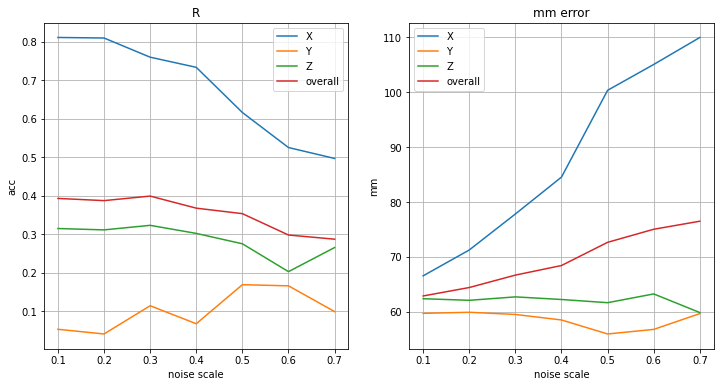

In [33]:
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.title("R")

plt.plot(noisescales,X,label='X')
plt.plot(noisescales,Y,label='Y')
plt.plot(noisescales,Z,label='Z')
plt.plot(noisescales,(np.array(X)+np.array(Y)+np.array(Z))/3,label='overall')
plt.grid('True')
plt.legend()
plt.xlabel('noise scale')
plt.ylabel('acc')

plt.subplot(122)
plt.title("mm error")
plt.plot(noisescales,Xm,label='X')
plt.plot(noisescales,Ym,label='Y')
plt.plot(noisescales,Zm,label='Z')
plt.plot(noisescales,(np.array(Xm)+np.array(Ym)+np.array(Zm))/3,label='overall')
plt.grid('True')
plt.legend()
plt.xlabel('noise scale')
plt.ylabel('mm')
plt.savefig('{}/validateerror.png'.format(model_name_to_save))

## case study 3

In [70]:
df2={}
address='third_case_study_y_direction/'
df2['x']= pd.read_csv(address+'x_str.txt', sep=r'\s{2,}', engine='python', header=None)
df2['y']= pd.read_csv(address+'y_str.txt', sep=r'\s{2,}', engine='python', header=None)
df2['z']= pd.read_csv(address+'z_str.txt', sep=r'\s{2,}', engine='python', header=None)
y_valid=pd.DataFrame(df2['x'][:477])
y_valid['x']=pd.DataFrame(df2['x'][:477]+500)
y_valid['y']=pd.DataFrame(df2['y'][:477]+250)
y_valid['z']=pd.DataFrame(df2['z'][:477]+250)
y_valid=y_valid.drop([0], axis=1)

index=1 #start number 5=>400
url_list=[]
for i in os.listdir(address):
    if i=='x_str.txt' or i=='y_str.txt' or i=='z_str.txt' or i[-3:]=='png' or i[-9:-5]=='freq' or i[-10:-5]=='noise':
          continue   
    else:  
        url_list.append(address+"res_{}.txt".format(index))
    index+=1 
    
y_valid

x           y           z
0    783.251318  282.899666  302.475494
1    865.212743  266.295735  192.029461
2    164.288135  397.976413  448.801309
3    872.038271  155.911611  139.668600
4    619.123322  177.229630  310.980429
..          ...         ...         ...
472  219.795779  311.479956  355.154838
473  308.748356  423.045429   83.185060
474  132.002117  115.404947  314.638477
475  568.588443  418.438902  256.791606
476  665.026919  367.863154  118.419207

[477 rows x 3 columns]

## implement

In [77]:
import os
import math

noisescales=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]  
X,Y,Z=[],[],[]
Xm,Ym,Zm=[],[],[]
progressbar = display(progress(0, len(url_list)*len(noisescales)), display_id=True)   
c3=1
for noisescale in noisescales:  
    data={}
    for c,url in enumerate(url_list):
        x_valid = pd.read_csv(url, sep=r'\s{2,}', engine='python', header=None, names=['time','port'])
        x_valid=x_valid.drop([0,1])
        x_valid.reset_index(drop=True,inplace=True) 
        x_valid=normalize(x_valid)   
        x_valid=cut_off(x_valid,10)
        x_valid.reset_index(drop=True,inplace=True)
        #x_valid['port'] =awgn(x_valid['port'].to_numpy().astype(np.float),target_snr_db= 0.1)
        noise = np.random.normal(0, noisescale, len(x_valid['port']))
        x_valid['port'] = x_valid['port'] + noise
        #data[c]=adventitious_differential(x_valid,4200,samplerate) 
        data[c]=simple(x_valid['port'])
        progressbar.update(progress(c3, len(url_list)*len(noisescales)))
        c3+=1                   

    x_valid=pd.DataFrame.from_dict(data, orient='index')
    x_valid=x_valid.iloc[:,:].values
    x_valid = x_valid.reshape(len(x_valid), x_valid.shape[1],1)

    c,c2=0,0
    errors={}
    validation={}
    for i in model.predict(x_valid):
        x,y,z=i
        x2,y2,z2=y_valid.to_numpy()[c2]
        validation[c]=[x,y,z,'predict']
        c+=1
        validation[c]=[x2,y2,z2,'real']
        c+=1
        c2+=1
        errors[c]=math.sqrt((x2-x)**2+(y2-y)**2+(z2-z)**2)

    validation=pd.DataFrame.from_dict(validation, orient='index',columns=['x','y','z','kind'])
    # Evaluate the model on the validate data using `evaluate`
    print("Evaluate on validate data")
    results = model.evaluate(x_valid, y_valid, batch_size=128)
    np.abs(validation[validation['kind'] == 'predict']['x']-validation[validation['kind'] == 'real']['x'])/len(validation['x'])
    X.append(np.corrcoef(validation[validation['kind'] == 'predict']['x'],validation[validation['kind'] == 'real']['x'])[0][1])
    Y.append(np.corrcoef(validation[validation['kind'] == 'predict']['y'],validation[validation['kind'] == 'real']['y'])[0][1])
    Z.append(np.corrcoef(validation[validation['kind'] == 'predict']['z'],validation[validation['kind'] == 'real']['z'])[0][1])
    Xm.append(np.sum(np.abs(validation[validation['kind'] == 'predict']['x'].to_numpy()-validation[validation['kind'] == 'real']['x'].to_numpy()))/len(validation['x'])) 
    Ym.append(np.sum(np.abs(validation[validation['kind'] == 'predict']['y'].to_numpy()-validation[validation['kind'] == 'real']['y'].to_numpy()))/len(validation['y']))
    Zm.append(np.sum(np.abs(validation[validation['kind'] == 'predict']['z'].to_numpy()-validation[validation['kind'] == 'real']['z'].to_numpy()))/len(validation['z']))
    
Audio('alarm.mp3',autoplay=True)    

Evaluate on validate data
6/6 [==============================] - 0s 27ms/step - loss: 4304.7070 - mean_squared_error: 3090.7966
Evaluate on validate data
6/6 [==============================] - 0s 16ms/step - loss: 4332.5791 - mean_squared_error: 3118.6687
Evaluate on validate data
6/6 [==============================] - 0s 16ms/step - loss: 4319.2241 - mean_squared_error: 3105.3135
Evaluate on validate data
6/6 [==============================] - 0s 16ms/step - loss: 4443.8613 - mean_squared_error: 3229.9509
Evaluate on validate data
6/6 [==============================] - 0s 40ms/step - loss: 4570.5820 - mean_squared_error: 3356.6716
Evaluate on validate data
6/6 [==============================] - 0s 38ms/step - loss: 4674.9521 - mean_squared_error: 3461.0415
Evaluate on validate data
6/6 [==============================] - 0s 41ms/step - loss: 4977.4653 - mean_squared_error: 3763.5549


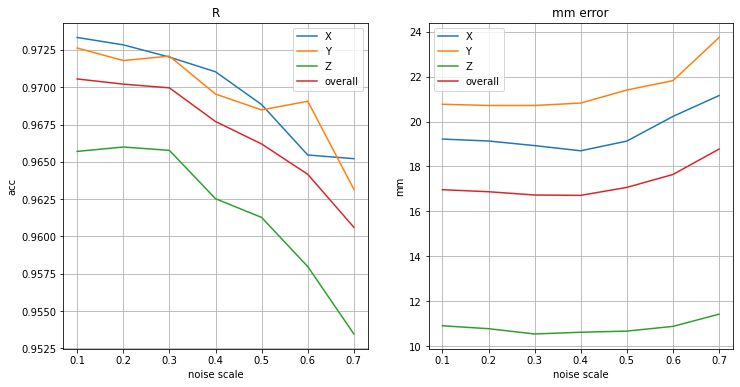

In [78]:
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.title("R")

plt.plot(noisescales,X,label='X')
plt.plot(noisescales,Y,label='Y')
plt.plot(noisescales,Z,label='Z')
plt.plot(noisescales,(np.array(X)+np.array(Y)+np.array(Z))/3,label='overall')
plt.grid('True')
plt.legend()
plt.xlabel('noise scale')
plt.ylabel('acc')

plt.subplot(122)
plt.title("mm error")
plt.plot(noisescales,Xm,label='X')
plt.plot(noisescales,Ym,label='Y')
plt.plot(noisescales,Zm,label='Z')
plt.plot(noisescales,(np.array(Xm)+np.array(Ym)+np.array(Zm))/3,label='overall')
plt.grid('True')
plt.legend()
plt.xlabel('noise scale')
plt.ylabel('mm')
plt.savefig('{}/validateerror.png'.format(model_name_to_save))